In [1]:
# General libraries
import os
import numpy as np
import math
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Data Visualization
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Chemical Data Processing
from rdkit import Chem
from rdkit.Chem import PandasTools, rdMolAlign, Draw
PandasTools.RenderImagesInAllDataFrames(images=True)

# Read in data

In [2]:
info_cols = ['Dataset', 'ID', 'PDB_ID', 'Ligand_Instance', 'Standardized_SMILES', 
             'NRB', 'Num_Heavy_Atoms', 'Pocket', 
             'MW', 'HBA', 'HBD', 'LogP', 'TPSA', 'NAR', 'NP-Likeness'] 
desc_cols = ['Fsp3', 'Fsp3_0.42', 'FCStereo', 'nSPS', 'nPBF', 'Sum_NPR', 'Sum_NPR_1.07']


def postprocess_df(df, suffix, grouped=False):
    # Keep only specified columns 
    cols_to_keep = info_cols + desc_cols 

    if suffix == 'protbound' and grouped == True:
        df = df[(cols_to_keep+['Num_Resolved_Atoms', 'Count'])]
    elif suffix == 'insilico' and grouped == True:
        df = df[(cols_to_keep+['Count'])]
    if grouped == False: 
        df = df[(cols_to_keep+['3D_Mol_H'])]

    for col in cols_to_keep: 
        # Try to convert columns to numeric datatype
        df[col] = pd.to_numeric(df[col], errors='coerce').combine_first(df[col])
    
    # Add a suffix to the column name
    for col in (desc_cols + ['3D_Mol_H']):
        df = df.rename(columns={col: f"{col}_{suffix}"})    

    # Set the PDB_ID column value to NaN for the Fragments
    df.loc[df['Dataset'] == 'CF', 'PDB_ID'] = np.nan

    print(len(df))

    return df


def read_sdf_in_dir(dir, suffix, info_cols=info_cols, desc_cols=desc_cols):

    # Initialize an empty list to hold DataFrames
    dataframes_list = []

    print("Currently processing ...")
    # Loop through all files in the specified directory
    for filename in os.listdir(dir):
        if filename.endswith('.sdf') and ("PDB" in filename or "CF" in filename) and ("Descriptor" in filename):

            print(filename)

            # Construct the full file path
            file_path = os.path.join(dir, filename)
        
            
            # Convert the molecules to a DataFrame
            sdf_df = PandasTools.LoadSDF(file_path, 
                                        smilesName='SMILES', 
                                        molColName='3D_Mol_H',
                                        includeFingerprints=False, 
                                        removeHs=False)
            
            # Append the DataFrame to the list
            dataframes_list.append(sdf_df)

    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(dataframes_list, ignore_index=True)

    df = postprocess_df(df, suffix)

    # Add 2D molecules with explicit hydrogen atoms
    df[f"2D_Mol_H_{suffix}"] = df["Standardized_SMILES"].apply(
    lambda smi: Chem.AddHs(Chem.MolFromSmiles(smi)) if smi else None)

    # Calculate the number of hydrogen atoms
    df[f"Num_H_Atoms_{suffix}"] = df[f"3D_Mol_H_{suffix}"].apply(
    lambda mol: sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 1) if mol else None)  

    return df       

Currently processing ...
All_Descriptor_Values_CF.sdf
All_Descriptor_Values_PDB.sdf
327


,Dataset,ID,PDB_ID,Ligand_Instance,Standardized_SMILES,NRB,Num_Heavy_Atoms,Pocket,MW,HBA,HBD,LogP,TPSA,NAR,NP-Likeness,Fsp3_protbound,Fsp3_0.42_protbound,FCStereo_protbound,nSPS_protbound,nPBF_protbound,Sum_NPR_protbound,Sum_NPR_1.07_protbound,3D_Mol_H_protbound,2D_Mol_H_protbound,Num_H_Atoms_protbound
0,CF,F001,NaN,001_B_2,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,3,18,X,250.253,4,2,0.2448,75.76,2,-1.393853,0.333333,False,0.166667,23.444444,0.032006,1.031809,False,,,13

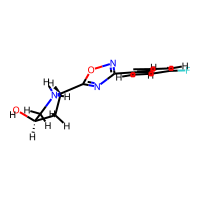
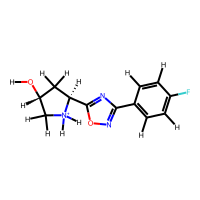

In [3]:
desc_path       = os.path.join('Analysis', 'Descriptors')
protbound_path  = os.path.join(desc_path,  'Protein_Bound_Conformations')
protbound_df    = read_sdf_in_dir(os.path.join(protbound_path, 'sdf_Files'), suffix='protbound')
protbound_df.head(1) 

In [4]:
print(os.path.join(protbound_path, 'sdf_Files'))

Analysis/Descriptors/Protein_Bound_Conformations/sdf_Files


Also read in the in silico generated conformations and the corresponding descriptor values for comparisons later on

Currently processing ...
All_Descriptor_Values_CF.sdf
All_Descriptor_Values_PDB.sdf
327


,Dataset,ID,PDB_ID,Ligand_Instance,Standardized_SMILES,NRB,Num_Heavy_Atoms,Pocket,MW,HBA,HBD,LogP,TPSA,NAR,NP-Likeness,Fsp3_insilico,Fsp3_0.42_insilico,FCStereo_insilico,nSPS_insilico,nPBF_insilico,Sum_NPR_insilico,Sum_NPR_1.07_insilico,3D_Mol_H_insilico,2D_Mol_H_insilico,Num_H_Atoms_insilico
0,CF,F001,NaN,001_B_2,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,3,18,X,250.253,4,2,0.2448,75.76,2,-1.393853,0.333333,False,0.166667,23.444444,0.047319,1.092296,True,,,13

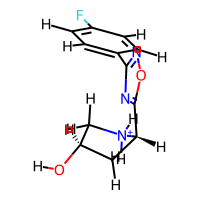
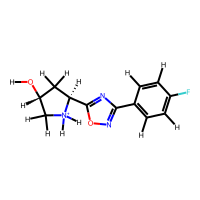

In [5]:
insilico_path      = os.path.join(desc_path,  'in_silico_Generated_Conformations')
in_silico_confs_df = read_sdf_in_dir(os.path.join(insilico_path, 'sdf_Files'), suffix='insilico')
in_silico_confs_df.head(1)

327


,Dataset,ID,PDB_ID,Ligand_Instance,Standardized_SMILES,NRB,Num_Heavy_Atoms,Pocket,MW,HBA,HBD,LogP,TPSA,NAR,NP-Likeness,Fsp3_protbound,Fsp3_0.42_protbound,FCStereo_protbound,nSPS_protbound,nPBF_protbound,Sum_NPR_protbound,Sum_NPR_1.07_protbound,3D_Mol_H_protbound,2D_Mol_H_protbound,Num_H_Atoms_protbound,Fsp3_insilico,Fsp3_0.42_insilico,FCStereo_insilico,nSPS_insilico,nPBF_insilico,Sum_NPR_insilico,Sum_NPR_1.07_insilico,3D_Mol_H_insilico,2D_Mol_H_insilico,Num_H_Atoms_insilico,2D_Mol
0,Fragment Hits,F001,NaN,001_B_2,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,3,18,X,250.253,4,2,0.2448,75.76,2,-1.393853,0.333333,False,0.166667,23.444444,0.032006,1.031809,False,,,13,0.333333,False,0.166667,23.444444,0.047319,1.092296,True,,,13,

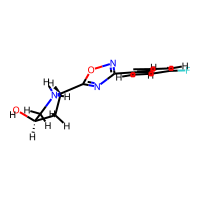
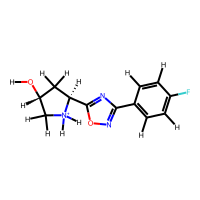
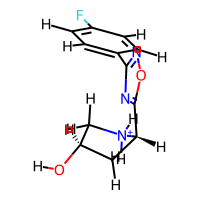
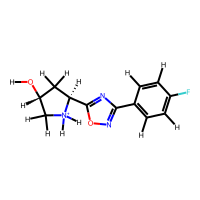
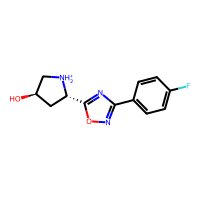

In [6]:
# Merge the in_silico_confs_df and the df dataframes
df = protbound_df.merge(in_silico_confs_df, on=info_cols, how='inner')
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="Standardized_SMILES", molCol='2D_Mol')

# Rename Dataset
df['Dataset'] = df['Dataset'].str.replace('CF', 'Fragment Hits')

print(len(df))
df.head(1)

# Compare Conformations (by means of RMSD)

In [7]:
comparison_path = os.path.join(desc_path,  'Comparison') 
conformation_comparison_path = os.path.join(comparison_path,  'Conformations') 
desc_comparison_path         = os.path.join(comparison_path,  'Descriptor_Values') 
av_desc_comparison_path      = os.path.join(comparison_path,  'Averaged_Descriptor_Values') 

,Dataset,ID,PDB_ID,Ligand_Instance,Standardized_SMILES,NRB,Num_Heavy_Atoms,Pocket,MW,HBA,HBD,LogP,TPSA,NAR,NP-Likeness,Fsp3_protbound,Fsp3_0.42_protbound,FCStereo_protbound,nSPS_protbound,nPBF_protbound,Sum_NPR_protbound,Sum_NPR_1.07_protbound,3D_Mol_H_protbound,2D_Mol_H_protbound,Num_H_Atoms_protbound,Fsp3_insilico,Fsp3_0.42_insilico,FCStereo_insilico,nSPS_insilico,nPBF_insilico,Sum_NPR_insilico,Sum_NPR_1.07_insilico,3D_Mol_H_insilico,2D_Mol_H_insilico,Num_H_Atoms_insilico,2D_Mol,3D_Mol_ProtBoundConf_RMSD,3D_Mol_insilico_RMSD,Nonhydrogen_Atom_RMSD
0,Fragment Hits,F001,NaN,001_B_2,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,3,18,X,250.253,4,2,0.2448,75.76,2,-1.393853,0.333333,False,0.166667,23.444444,0.032006,1.031809,False,,,13,0.333333,False,0.166667,23.444444,0.047319,1.092296,True,,,13,,,,1.191582

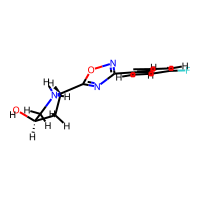
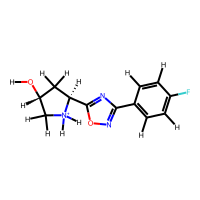
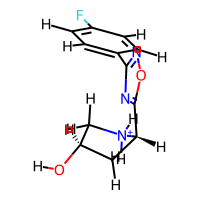
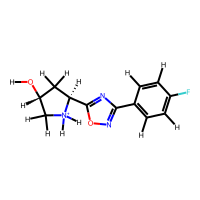
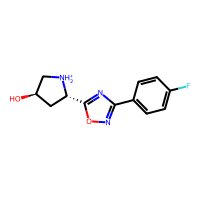
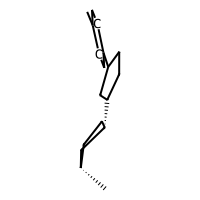
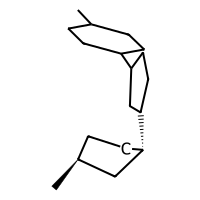

In [8]:
# When just thinking about the RMSD calculation, a trick like an abstraction (converting all non-hydrogen atoms to carbon, 
# and converting all bonds to single bonds) would also circumvent all the mismatching issues originating from 
# differing protonation states/tautomeric forms; aromaticity/perception issues or mismatched bond orders, 
# as the RMSD focusses on the molecular shape rather than chemistry anyways

def make_mol_abstract(mol):
    """
    Simplifies a molecule for shape-only RMSD by:
    - removing all hydrogens
    - converting all heavy atoms to carbon
    - converting all bonds to single
    """
    if mol is None:
        return None

    try:
        mol = Chem.RWMol(Chem.RemoveAllHs(mol))

        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() != 1:
                atom.SetAtomicNum(6)      # Carbon
                atom.SetFormalCharge(0)
                atom.SetIsAromatic(False)

        for bond in mol.GetBonds():
            bond.SetBondType(Chem.rdchem.BondType.SINGLE)
            bond.SetIsAromatic(False)

        Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
        return mol

    except Exception as e:
        print(f"Error in abstraction of molecule: {e}")
        return None
    

def compute_rmsd_abstract(mol1, mol2):
    if mol1 is None or mol2 is None:
        return "Error: One or both conformers are missing."

    try:
        abstract_mol1 = make_mol_abstract(mol1)
        abstract_mol2 = make_mol_abstract(mol2)

        rmsd = rdMolAlign.GetBestRMS(abstract_mol1, abstract_mol2)
        return pd.Series([abstract_mol1, abstract_mol2, rmsd])

    except Exception as e:
        return pd.Series([abstract_mol1, abstract_mol2, f"Error in RMSD calculation: {str(e)}"]) 

# Compute the RMSD values for the two conformations, using only non-hydrogen atoms 
df[["3D_Mol_ProtBoundConf_RMSD", "3D_Mol_insilico_RMSD", "Nonhydrogen_Atom_RMSD"]] = df.apply(
    lambda row: compute_rmsd_abstract(row["3D_Mol_H_protbound"], row["3D_Mol_H_insilico"]), axis=1)

df.head(1)

In [9]:
# Convert to Numeric
def round_numeric_values(val):
    try:
        return round(float(val), 1)  # Try to convert to float and round
    except (ValueError, TypeError):
        return np.NAN                # Return NaN if conversion fails

# Apply the function to the column
df["Nonhydrogen_Atom_RMSD_Numeric"] = df["Nonhydrogen_Atom_RMSD"].apply(round_numeric_values)

print(f"{round((df['Nonhydrogen_Atom_RMSD_Numeric'] <= 2.0).sum()/len(df)*100, 1)}% RMSD <= 2.0 Å")
print(f"{round((df['Nonhydrogen_Atom_RMSD_Numeric'] >  2.0).sum()/len(df)*100, 1)}% RMSD >  2.0 Å\n")
print(f"Median RMSD = {round(np.nanmedian(df['Nonhydrogen_Atom_RMSD_Numeric']), 1)} Å \n")

80.7% RMSD <= 2.0 Å
19.3% RMSD >  2.0 Å

Median RMSD = 1.3 Å 



In [10]:
# # Print Errors
# print(df[df["Nonhydrogen_Atom_RMSD"].str.startswith('Error', na=False)]["Nonhydrogen_Atom_RMSD"].value_counts(), "\n")

# error_df = df[df["Nonhydrogen_Atom_RMSD"].str.startswith('Error', na=False)]

# error_lig_inst = error_df['Ligand_Instance'].to_list()

# # Do they include all the ligands, for which not all atoms have been resolved? 
# # print(sorted([lig for lig in error_lig_inst if lig in ligand_copies_to_keep]))
# # Only some of them, so this cannot be the only issue!
# error_df.to_html(os.path.join(comparison_path, 'RMSD_Computation_Failed.html'))

## Histogram RMSD

In [11]:
def plot_histogram(data, title, color, bin_edges, x_label, y_label, 
                   figsize=(12,6), y_limit=None, x_cutoff=None, bin_centers=True, filename=None):
    
    plt.figure(figsize=figsize)

    counts, bins, patches = plt.hist(data, bins=bin_edges, color=color, edgecolor='black')
    plt.title(title, color=color)

    # Settings for the x-axis
    if bin_centers == True:
        bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Calculate bin centers
        plt.xticks(bin_centers, rotation=90)        # Set x-ticks to bin centers and rotate labels
    else: 
        plt.xticks(bin_edges, rotation=90)

    plt.xlabel(x_label)                          # Set x-axis label  

    # Add a vertical line at the cutoff value if provided
    if x_cutoff is not None:
        plt.axvline(x=x_cutoff, color='gray', linestyle='--', linewidth=1)

    # Settings for the y-axis
    plt.ylabel(y_label)
    if y_limit:
        plt.ylim(0, y_limit)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Add frequency counts above bars
    for count, patch in zip(counts, patches):
        if y_limit and count > y_limit: 
            plt.text(patch.get_x() + patch.get_width() / 2, y_limit,  # Centered label
                     f"{int(count)}", ha='center', va='bottom', fontsize=10, fontweight='bold')
        elif count > 0:  # Only label non-zero counts
            height = patch.get_height()
            plt.text(patch.get_x() + patch.get_width() / 2, height,  # Centered label
                     f"{int(count)}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add textbox (top right): Number of data points
    plt.text(0.95, 0.95, f'N = {len(data)}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    # Add textbox (top left): Percentage of ligands with RMSD <= cutoff and median
    if x_cutoff is not None:
        median = np.nanmedian(data)
        percentage = 100 * (data <= x_cutoff).sum() / len(data)
        text =  f'{percentage:.0f}% copies posses a RMSD ≤ {x_cutoff:.1f} Å \nMedian RMSD = {median:.1f} Å'
        plt.text(0.02, 0.95, text,
                    transform=plt.gca().transAxes, fontsize=11,
                    verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Show the plot
    plt.tight_layout()

    if filename: 
        plt.savefig(filename)

    plt.show()

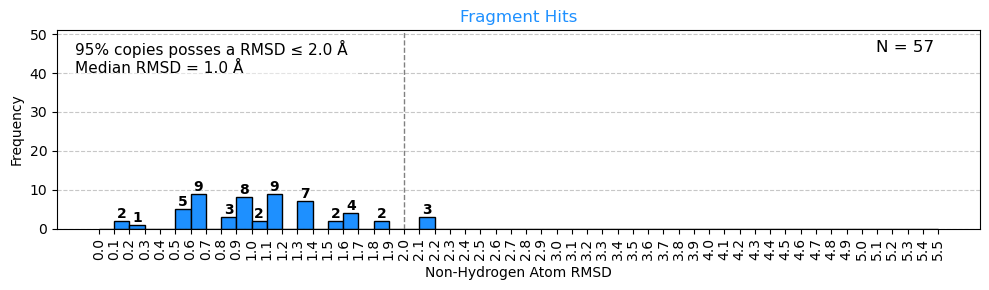

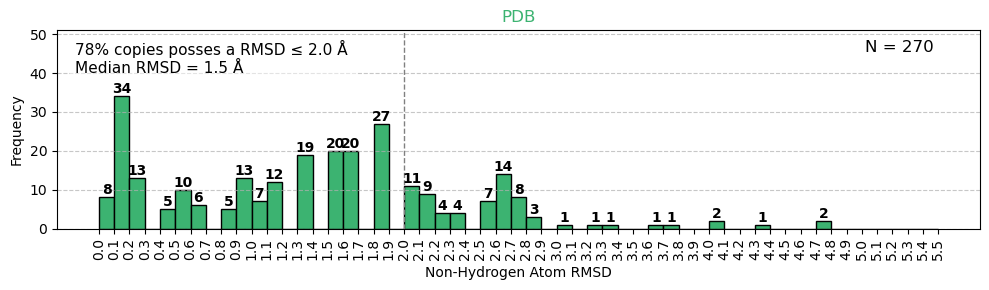

In [12]:
# Data for CF and PDB datasets (based on your example)
cf_data  = df[df['Dataset'] == 'Fragment Hits']['Nonhydrogen_Atom_RMSD_Numeric'].dropna()
pdb_data = df[df['Dataset'] == 'PDB']['Nonhydrogen_Atom_RMSD_Numeric'].dropna()

# Define the bin edges for this dataset
bin_edges = np.arange(0, df['Nonhydrogen_Atom_RMSD_Numeric'].max(), 0.1)

# Create histograms for both datasets using the generalized function
figsize = (10,3)
x_label = 'Non-Hydrogen Atom RMSD'
y_label = 'Frequency'
y_limit = 51
x_cutoff = 2.0
bin_centers = False

plot_histogram(cf_data, title='Fragment Hits', color='dodgerblue', bin_edges=bin_edges, figsize=figsize,
               x_label=x_label, y_label=y_label, y_limit=y_limit, x_cutoff=x_cutoff, bin_centers=bin_centers, 
               filename=os.path.join(conformation_comparison_path, 'Histogram_RMSD_CF.png'))

plot_histogram(pdb_data, title='PDB', color='mediumseagreen', bin_edges=bin_edges, figsize=figsize,
               x_label=x_label, y_label=y_label,  y_limit=y_limit, x_cutoff=x_cutoff, bin_centers=bin_centers, 
               filename=os.path.join(conformation_comparison_path, 'Histogram_RMSD_PDB.png'))

## Ligands with the highest RMSD values

,Dataset,ID,PDB_ID,Ligand_Instance,Standardized_SMILES,NRB,Num_Heavy_Atoms,Pocket,MW,HBA,HBD,LogP,TPSA,NAR,NP-Likeness,Fsp3_protbound,Fsp3_0.42_protbound,FCStereo_protbound,nSPS_protbound,nPBF_protbound,Sum_NPR_protbound,Sum_NPR_1.07_protbound,3D_Mol_H_protbound,2D_Mol_H_protbound,Num_H_Atoms_protbound,Fsp3_insilico,Fsp3_0.42_insilico,FCStereo_insilico,nSPS_insilico,nPBF_insilico,Sum_NPR_insilico,Sum_NPR_1.07_insilico,3D_Mol_H_insilico,2D_Mol_H_insilico,Num_H_Atoms_insilico,2D_Mol,3D_Mol_ProtBoundConf_RMSD,3D_Mol_insilico_RMSD,Nonhydrogen_Atom_RMSD,Nonhydrogen_Atom_RMSD_Numeric
138,PDB,A02,3AG9,3AG9_A02_B_351,[H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(N2C([...,36,67,A,950.141,14,16,-8.3800,462.82,2,0.190946,0.675000,True,0.175000,17.955224,0.032796,1.196523,True,,,73,0.675000,True,0.175000,17.955224,0.031864,1.327242,True,,,73,,,,5.626170,5.6
139,PDB,A03,3AGL,3AGL_A03_A_351,[H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(N2C([...,32,63,A,892.037,14,15,-7.7723,435.18,2,0.116726,0.648649,True,0.189189,18.333333,0.025365,1.124334,True,,,65,0.648649,True,0.189189,18.333333,0.030542,1.245975,True,,,65,,,,4.785291,4.8
140,PDB,A03,3AGL,3AGL_A03_B_351,[H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(N2C([...,32,63,A,892.037,14,15,-7.7723,435.18,2,0.116726,0.648649,True,0.189189,18.333333,0.025476,1.122469,True,,,65,0.648649,True,0.189189,18.333333,0.030542,1.245975,True,,,65,,,,4.759937,4.8
178,PDB,ARX,3BWJ,3BWJ_ARX_A_352,[H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(N2C([...,23,50,G,707.798,12,13,-7.9536,376.98,2,0.238602,0.607143,True,0.214286,19.640000,0.029730,1.169523,True,,,49,0.607143,True,0.214286,19.640000,0.036359,1.291694,True,,,49,,,,4.322382,4.3

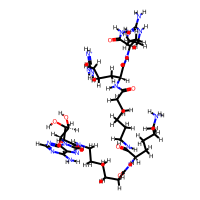
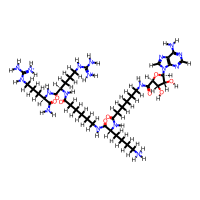
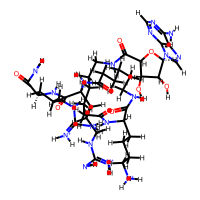
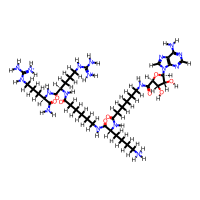
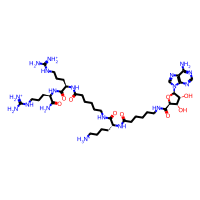
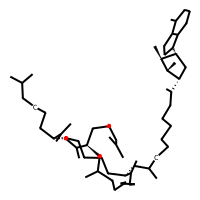
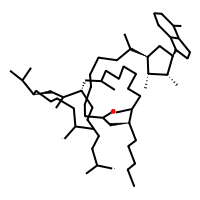
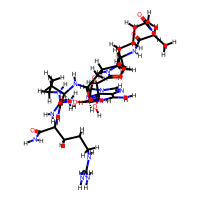
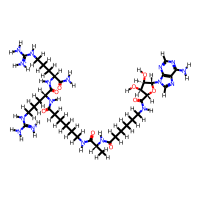
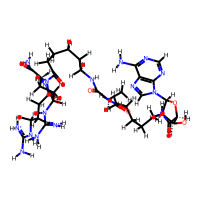
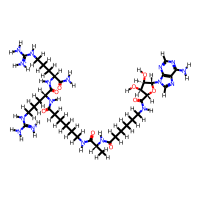
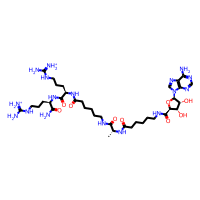
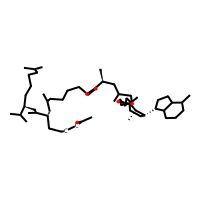
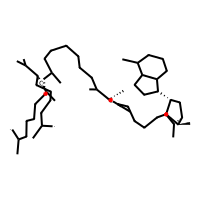
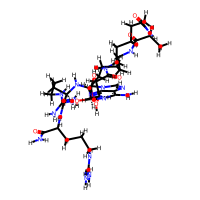
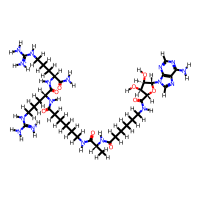
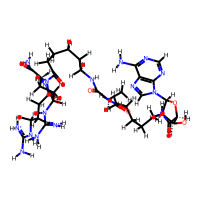
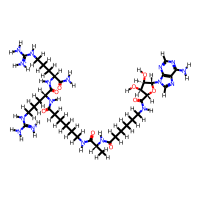
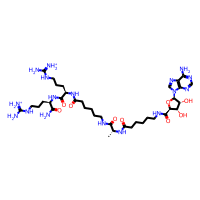
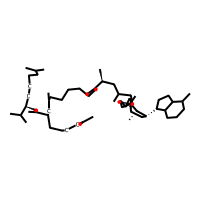
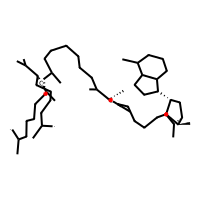
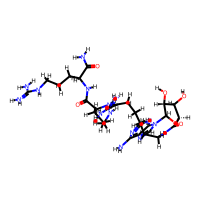
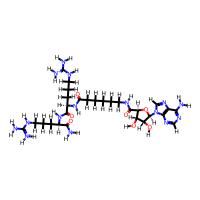
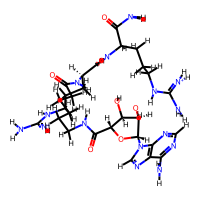
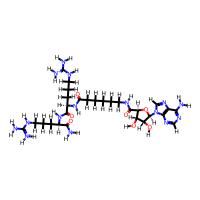
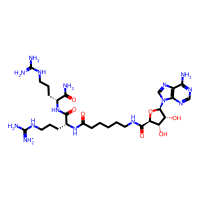
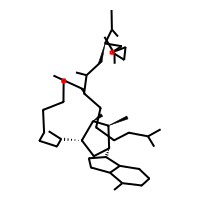
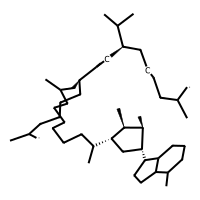

In [13]:
# Ligands with the highest deviations
df = df.sort_values(by=['Nonhydrogen_Atom_RMSD_Numeric', 'Num_Heavy_Atoms'], ascending=[False, True])#.reset_index(drop=True)
df.head(4)

## Scatter plots

In [14]:
# Define a mapping of dataset names to colors
color_map = {'Fragment Hits'    : 'dodgerblue', 'PDB'   : 'mediumseagreen'}

# Correlation between RMSD and .... ?
def scatter_plotter(df, x_col, y_col, color_map=color_map, x_label=None, y_label=None, filename=None):
    """
    Create a scatter plot with points colored by dataset. Optionally, add a regression line and R² value.

    Parameters:
    df (DataFrame):            The DataFrame containing the data for plotting.
    x_col (str):               The name of the column for the x-axis.
    y_col (str):               The name of the column for the y-axis.
    color_map (dict):          A dictionary mapping dataset names to colors.
    """
    plt.figure(figsize=(10, 5))  # Set the figure size

    legend_labels = []  # Store legend labels with dataset sizes

    # Create a scatter plot for each dataset using the color map
    for dataset, color in color_map.items():
        subset = df[df['Dataset'] == dataset]
        subset = subset.dropna(subset=[x_col, y_col])
        plt.scatter(subset[x_col], subset[y_col], alpha=0.7, color=color, label=dataset)
        legend_labels.append(f"{dataset} (N={len(subset)})")
    # plt.scatter(df[x_col], df[y_col], alpha=0.7, color='gray')

    # Set x- and y-axis labels
    plt.xlabel(x_label if x_label else x_col, fontsize=12)
    plt.ylabel(y_label if y_label else y_col, fontsize=12)

    # Check for linear correlation
    # Remove NaNs and ensure numeric values
    df_clean = df[[x_col, y_col]].dropna()
    x_values = df_clean[x_col].values.reshape(-1, 1)
    y_values = df_clean[y_col].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    r2 = r2_score(y_values, y_pred)
    print(f"Linear Correlation: \t Pearson Correlation Coefficient (R²) \t\t {r2:.3f}")

    # In case of moderate/strong linear correlation, display the regression line and the R2 coefficient 
    if r2 >= 0.4:
        # Plot regression line
        x_range = np.linspace(min(x_values), max(x_values), 100).reshape(-1, 1)
        y_range = model.predict(x_range)
        plt.plot(x_range, y_range, color='black', linestyle='--', linewidth=2, label=f'R² = {r2:.3f}')
        # Add R² value as a separate legend entry
        legend_labels.append(f"R² (Fragments + PDB) = {r2:.3f}")

    # Additionally: Spearman rank correlation
    from scipy.stats import spearmanr
    rho, pval = spearmanr(df_clean[x_col], df_clean[y_col], nan_policy='omit')
    #if abs(rho) >= 0.3:
    print(f"Monotonic Correlation: \t Spearman's Rank Correlation Coefficient (ρ) \t {rho:.3f}")

    # Add a legend
    plt.legend(labels=legend_labels)

    # Show the plot
    plt.tight_layout()
    if filename: 
        plt.savefig(filename)

In [15]:
x_col   = 'Nonhydrogen_Atom_RMSD_Numeric'
x_label = 'Non-Hydrogen Atom RMSD [Å] \n (protein-bound vs. in silico-generated ligand conformation)'

#### RMSD vs. molecular size (number of non-hydrogen atoms)

Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.719
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 0.835


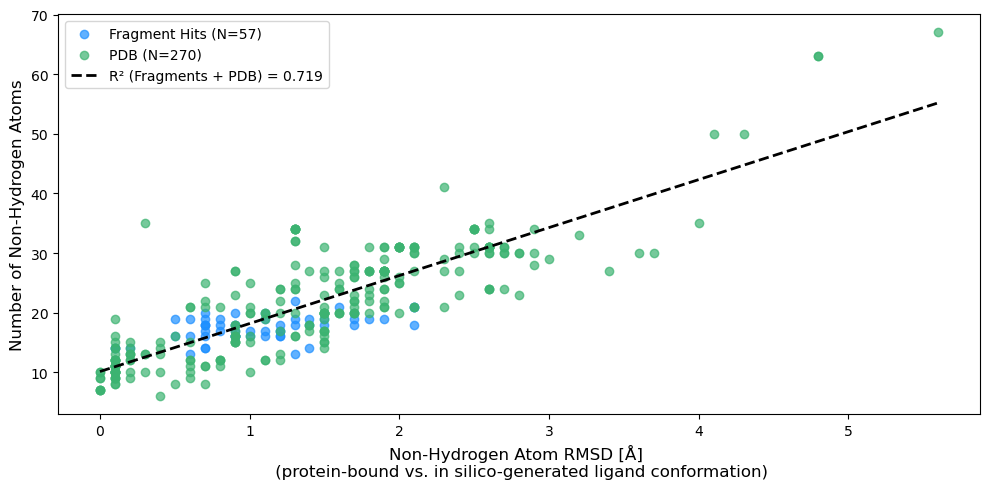

In [16]:
scatter_plotter(df, 
                y_col = 'Num_Heavy_Atoms', y_label = 'Number of Non-Hydrogen Atoms',
                x_col = x_col,             x_label = x_label, 
                filename=os.path.join(conformation_comparison_path, 'Scatterplot_NonHAtoms_vs_RMSD.png'))

#### RMSD vs. molecular flexibility (number of rotatable bonds)

Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.574
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 0.727


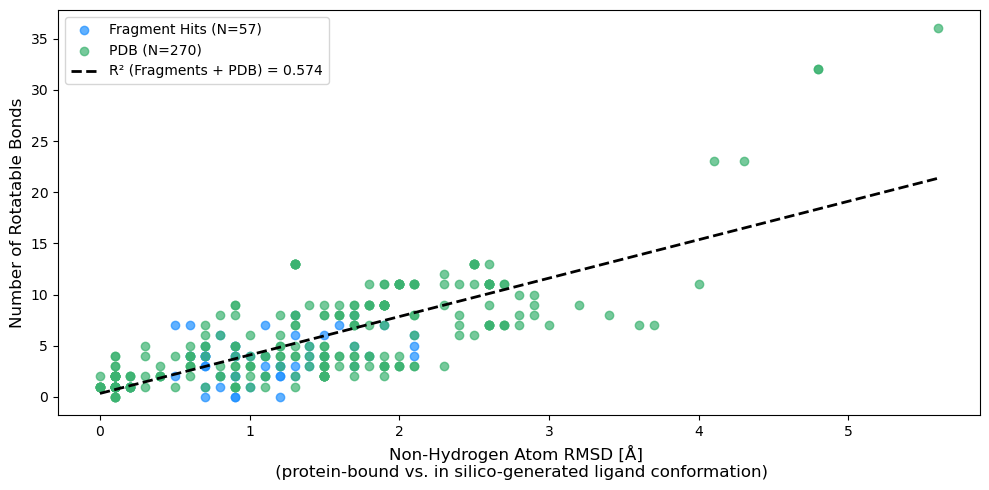

In [17]:
scatter_plotter(df, 
                y_col = 'NRB',    y_label = 'Number of Rotatable Bonds',
                x_col = x_col,    x_label = x_label, 
                filename=os.path.join(conformation_comparison_path, f'Scatterplot_NRB_vs_RMSD.png'))

# Save to .sdf file

In [18]:
def prepare_df_for_saving(df, save_cols): 
    save_df = df[df['Dataset']=='Fragment Hits'][save_cols]
    save_df = save_df.sort_values(by=['ID', 'Ligand_Instance']).reset_index(drop=True)
    save_df.rename(columns={'Fsp3_protbound':'Fsp3', 'FCStereo_protbound':'FCStereo', 'nSPS_protbound':'nSPS'}, inplace=True)
    return save_df

In [19]:
def save_dataframe_to_sdf(dataset, filename, molColName, idName):
    """
    Helper function to save a DataFrame  as an SDF file.

    Parameters:
    dataset (DataFrame):  The DataFrame to be saved.
    filename (str):       The path and name of the SDF file.
    molColName (str):     The name of the molecule column.
    idName (str):         The column to serve as the molecule title.
    sdf_cols (list):      List of properties to export.
    """

    sdf_cols = [col for col in dataset.columns if col not in ('SMILES', '2D_Mol', molColName)]

    PandasTools.WriteSDF(dataset,                    # Sub-Dataframe to be saved
                         filename,                   # Path and name of .sdf file
                         molColName=molColName,      # Name of the molecule column
                         idName=idName,              # Select a column to serve as molecule title
                         properties=sdf_cols,        # List of properties to export
                         allNumeric=False,           # Automatically include all numeric columns in the output
                         forceV3000=True             # Use the .sdf file V3000 format
                         )

In [20]:
save_cols = ['ID', 'Ligand_Instance', 'Standardized_SMILES', 'Pocket', 
            'Fsp3_protbound', 'FCStereo_protbound', 'nSPS_protbound',  'nPBF_protbound', 'nPBF_insilico', 
            '3D_Mol_H_insilico', 'Nonhydrogen_Atom_RMSD_Numeric'] #'2D_Mol', '3D_Mol_H_protbound'

save_dataframe_to_sdf(prepare_df_for_saving(df, save_cols), 
                      os.path.join(desc_path, 'Fragments_Descriptor_Values.sdf'), 
                      '3D_Mol_H_insilico', 
                      'ID')

# Compare Descriptor Values

In [21]:
def compare_descriptor_deltas(df, desc_cols=desc_cols):
  """   
  This function adds the following columns to the dataframe df:
    - Delta_Sum_NPR_1.07: Boolean: True if Sum_NPR_1.07 equals Sum_NPR_1.07_insilico.
    - Delta_Sum_NPR_1.2:  Boolean: True if Sum_NPR_1.2 equals Sum_NPR_1.2_insilico.
    - Delta_Sum_NPR:      Difference between Sum_NPR and Sum_NPR_insilico.
    - Delta_Abs_Sum_NPR:  Absolute difference for Sum_NPR descriptors.

    - Delta_nPBF:         Difference between nPBF and nPBF_insilico.
    - Delta_Abs_nPBF:     Absolute difference for nPBF descriptors.
  """
  
  # print(f"Number of Ligands/Ligand Copies per {df['Dataset'].value_counts()}\n")

  print(f"# (out of {len(df)}) Ligands copies show different descriptor values for protbound vs. insilico:")
  for desc in desc_cols: 
    df[f"Same_{desc}"] = df[f"{desc}_protbound"] == df[f"{desc}_insilico"]
    print(f"{len(df[df[f'Same_{desc}'] == False])} \t {desc}") 
  
  # Compute (absolute) difference for Sum_NPR
  for desc in ['Sum_NPR', 'nPBF']: 
    df[f"Delta_{desc}"] = df[f"{desc}_protbound"] - df[f"{desc}_insilico"]
    df[f"Delta_Abs_{desc}"]  = abs(df[f"Delta_{desc}"])

    print(f"\nFor {(df[f'Delta_{desc}'] > 0).sum()} ligands, the {desc} value is higher for the protein-bound conformation than for the in silico generated one,")
    print(f"while the opposite is true for {(df[f'Delta_{desc}'] < 0).sum()} ligands (from both datasets).")
    print(f"For {(df[f'Delta_{desc}'] == 0).sum()} ligands, the {desc} values are exactly the same.\n")

    print(f"The maximal absolute difference in the {desc} descriptor values computed from the protein-bound vs. the in silico generated conformation is for: ")
    df = df.sort_values(by=[f"Delta_Abs_{desc}"], ascending=False)
    print(df[['ID', #'Ligand_Instance', 
              f"Delta_{desc}", f"{desc}_protbound", f"{desc}_insilico"]].head(5))
    
  return df

In [22]:
def compare_descriptor_deltas_by_dataset(df, desc_cols=desc_cols):
    """
    Applies the compare_descriptor_deltas function to each 'Dataset'.
    Only prints the analysis, does not return anything.
    """
    for dataset_name, group in df.groupby("Dataset"):
        print(f"\n=== Dataset: {dataset_name} ===")
        compare_descriptor_deltas(group.copy(), desc_cols=desc_cols)

In [23]:
df = compare_descriptor_deltas(df)

df = df.sort_values(by=['Dataset', 'ID', 'PDB_ID', 'Ligand_Instance']).reset_index(drop=True)
df.to_excel(os.path.join(comparison_path, "Comparison_Descriptor_Values.xlsx"), index=False)

# (out of 327) Ligands copies show different descriptor values for protbound vs. insilico:
0 	 Fsp3
0 	 Fsp3_0.42
0 	 FCStereo
0 	 nSPS
327 	 nPBF
327 	 Sum_NPR
50 	 Sum_NPR_1.07

For 110 ligands, the Sum_NPR value is higher for the protein-bound conformation than for the in silico generated one,
while the opposite is true for 217 ligands (from both datasets).
For 0 ligands, the Sum_NPR values are exactly the same.

The maximal absolute difference in the Sum_NPR descriptor values computed from the protein-bound vs. the in silico generated conformation is for: 
       ID  Delta_Sum_NPR  Sum_NPR_protbound  Sum_NPR_insilico
175   AO8      -0.225385           1.064105          1.289490
54   F312      -0.222942           1.136448          1.359390
11   F058       0.219120           1.307011          1.087891
176   AO8      -0.212008           1.077482          1.289490
174   AO8      -0.207991           1.081499          1.289490

For 112 ligands, the nPBF value is higher for the protein-bo

In [24]:
compare_descriptor_deltas_by_dataset(df, desc_cols=desc_cols)


=== Dataset: Fragment Hits ===
# (out of 57) Ligands copies show different descriptor values for protbound vs. insilico:
0 	 Fsp3
0 	 Fsp3_0.42
0 	 FCStereo
0 	 nSPS
57 	 nPBF
57 	 Sum_NPR
15 	 Sum_NPR_1.07

For 23 ligands, the Sum_NPR value is higher for the protein-bound conformation than for the in silico generated one,
while the opposite is true for 34 ligands (from both datasets).
For 0 ligands, the Sum_NPR values are exactly the same.

The maximal absolute difference in the Sum_NPR descriptor values computed from the protein-bound vs. the in silico generated conformation is for: 
      ID  Delta_Sum_NPR  Sum_NPR_protbound  Sum_NPR_insilico
54  F312      -0.222942           1.136448          1.359390
11  F058       0.219120           1.307011          1.087891
55  F313      -0.154212           1.065159          1.219371
3   F012      -0.103346           1.011749          1.115095
4   F024      -0.103250           1.143180          1.246430

For 26 ligands, the nPBF value is highe

,Dataset,ID,PDB_ID,Ligand_Instance,Standardized_SMILES,NRB,Num_Heavy_Atoms,Pocket,MW,HBA,HBD,LogP,TPSA,NAR,NP-Likeness,Fsp3_protbound,Fsp3_0.42_protbound,FCStereo_protbound,nSPS_protbound,nPBF_protbound,Sum_NPR_protbound,Sum_NPR_1.07_protbound,3D_Mol_H_protbound,2D_Mol_H_protbound,Num_H_Atoms_protbound,Fsp3_insilico,Fsp3_0.42_insilico,FCStereo_insilico,nSPS_insilico,nPBF_insilico,Sum_NPR_insilico,Sum_NPR_1.07_insilico,3D_Mol_H_insilico,2D_Mol_H_insilico,Num_H_Atoms_insilico,2D_Mol,3D_Mol_ProtBoundConf_RMSD,3D_Mol_insilico_RMSD,Nonhydrogen_Atom_RMSD,Nonhydrogen_Atom_RMSD_Numeric,Same_Fsp3,Same_Fsp3_0.42,Same_FCStereo,Same_nSPS,Same_nPBF,Same_Sum_NPR,Same_Sum_NPR_1.07,Delta_Sum_NPR,Delta_Abs_Sum_NPR,Delta_nPBF,Delta_Abs_nPBF
0,Fragment Hits,F001,NaN,001_B_2,[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3=C...,3,18,X,250.253,4,2,0.2448,75.76,2,-1.393853,0.333333,False,0.166667,23.444444,0.032006,1.031809,False,,,13,0.333333,False,0.166667,23.444444,0.047319,1.092296,True,,,13,,,,1.191582,1.2,True,True,True,True,False,False,False,-0.060487,0.060487,-0.015313,0.015313

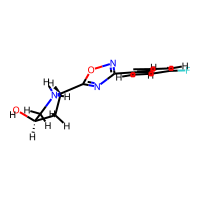
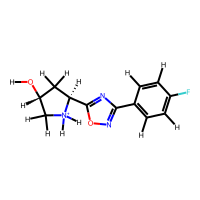
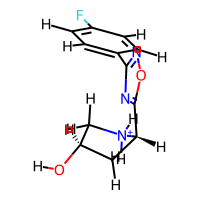
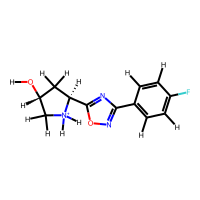
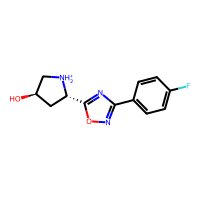
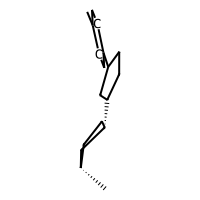
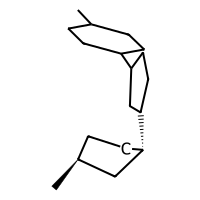

In [25]:
df.head(1)

### Scatter Plots

In [26]:
def plot_all_scatter_plots(df, dir, incl_vs_RMSD):
    # List of all x_col and x_label combinations for scatter plotting
    x_params = [
        ('Num_Heavy_Atoms',                 'Number of Non-Hydrogen Atoms'),
        ('NRB',                             'Number of Rotatable Bonds'),
    ]

    # List of all y_col and y_label combinations for scatter plotting
    y_params = [
        ('Delta_nPBF',          '∆nPBF \n (protein-bound vs. in silico-generated conformation)'),
        ('Delta_Abs_nPBF',      'Absolute ∆nPBF \n (protein-bound vs. in silico-generated conformation)'),
        ('Delta_Sum_NPR',       '∆ΣNPR \n (protein-bound vs. in silico-generated conformation)'),
        ('Delta_Abs_Sum_NPR',   'Absolute ∆ΣNPR \n (protein-bound vs. in silico-generated conformation)')
    ]

    if incl_vs_RMSD == True:
        x_params.append(('Nonhydrogen_Atom_RMSD_Numeric',   
                         'Non-Hydrogen Atom RMSD [Å] \n (protein-bound vs. in silico-generated ligand conformation)'))

    # Iterate over each y_col and y_label combination 
    for y_col, y_label in y_params:
        # Iterate over each x_col and x_label combination 
        for x_col, x_label in x_params:
            # For cleaner names, rename x_col  
            x_col_name = 'RMSD' if 'RMSD' in x_col else x_col
            # Print which parameters are plotted against each other
            print(f"\n {y_col} vs. {x_col_name}")
            # Build the file path
            filename = os.path.join(dir, f'Scatterplot_{y_col}_vs_{x_col_name}.png')
            # Call the function to do the actual plotting
            scatter_plotter(df, x_col=x_col, x_label=x_label, y_col=y_col, y_label=y_label, filename=filename)


 Delta_nPBF vs. Num_Heavy_Atoms
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.000
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 -0.035

 Delta_nPBF vs. NRB
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.006
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 -0.125

 Delta_nPBF vs. RMSD
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.001
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 -0.086

 Delta_Abs_nPBF vs. Num_Heavy_Atoms
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.008
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 -0.028

 Delta_Abs_nPBF vs. NRB
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.000
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 0.129

 Delta_Abs_nPBF vs. RMSD
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.000
Monotonic Correlation: 	 Spearman's Ran

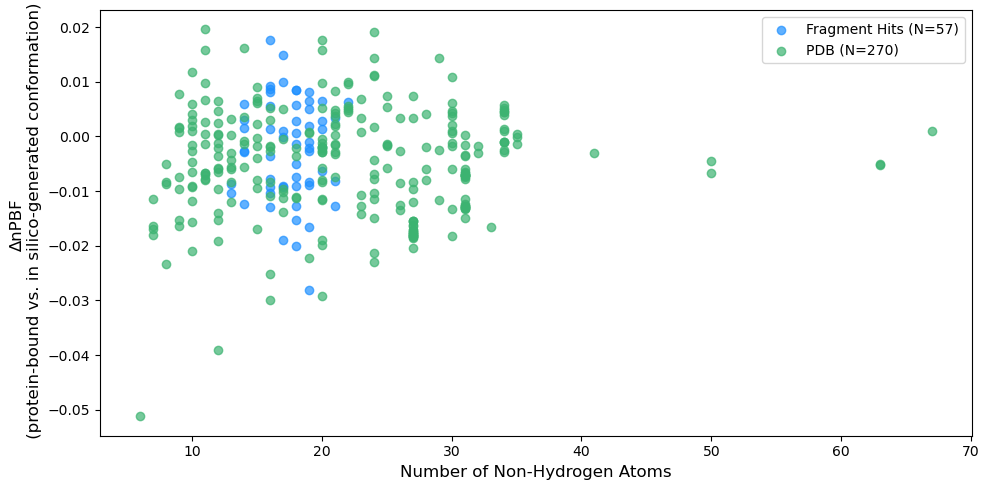

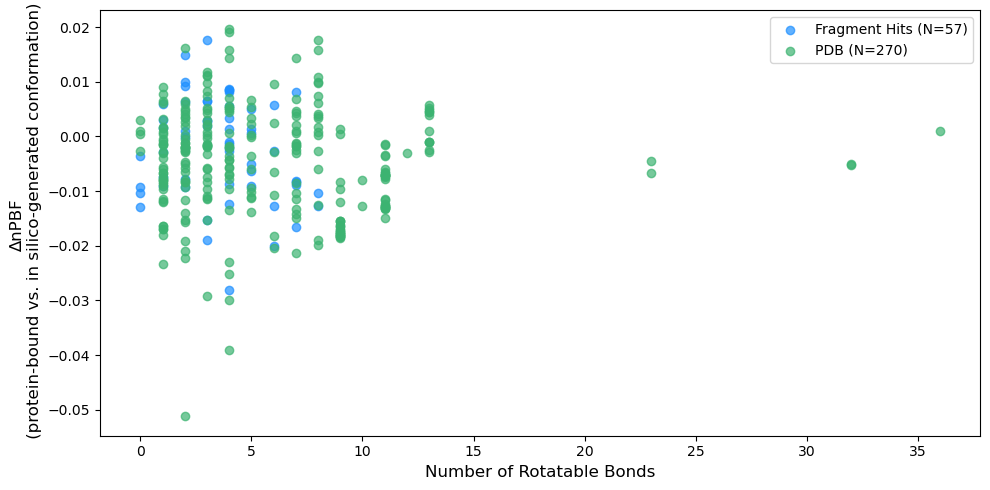

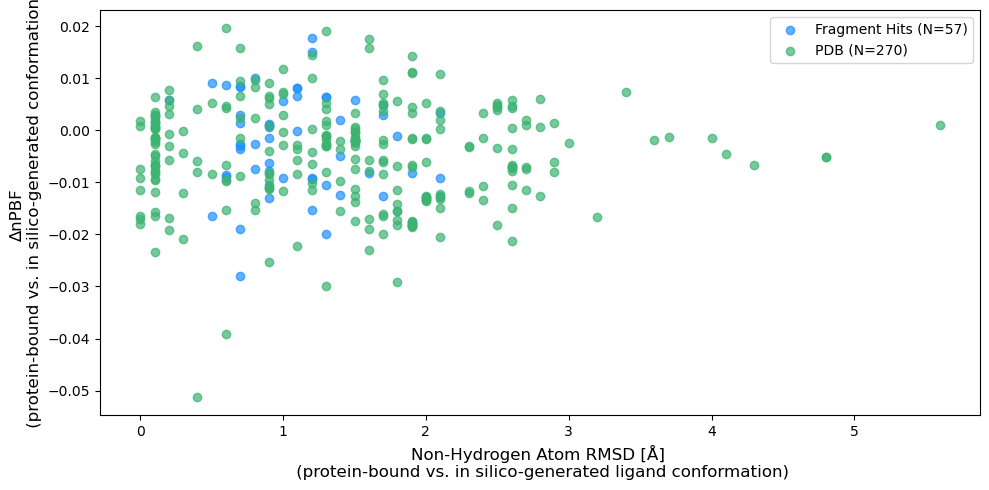

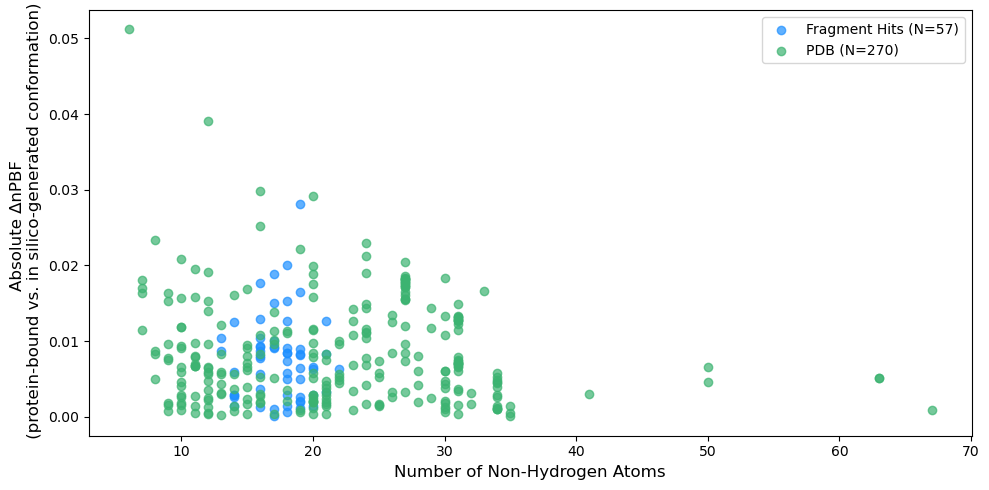

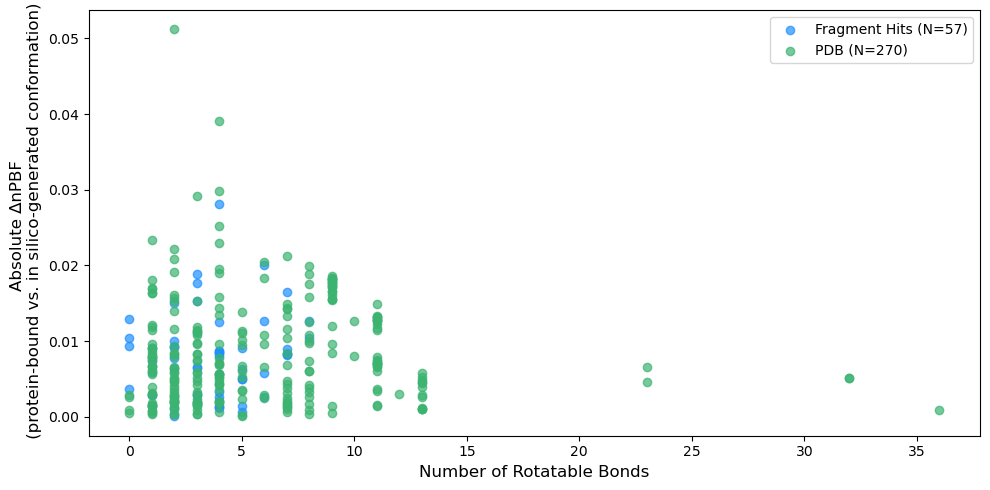

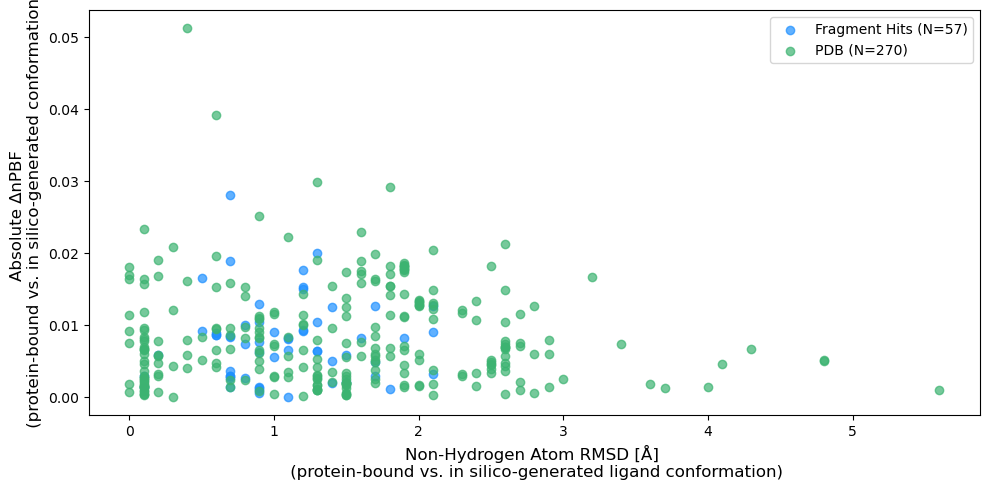

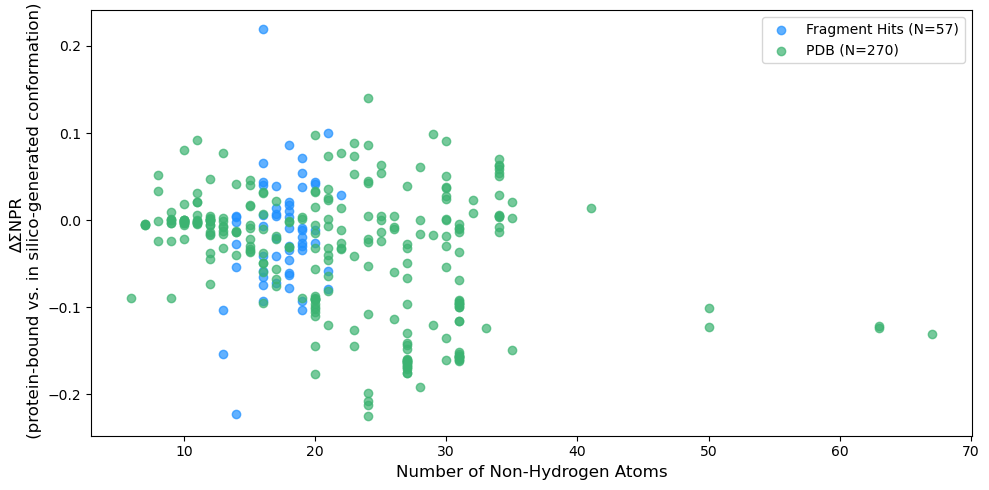

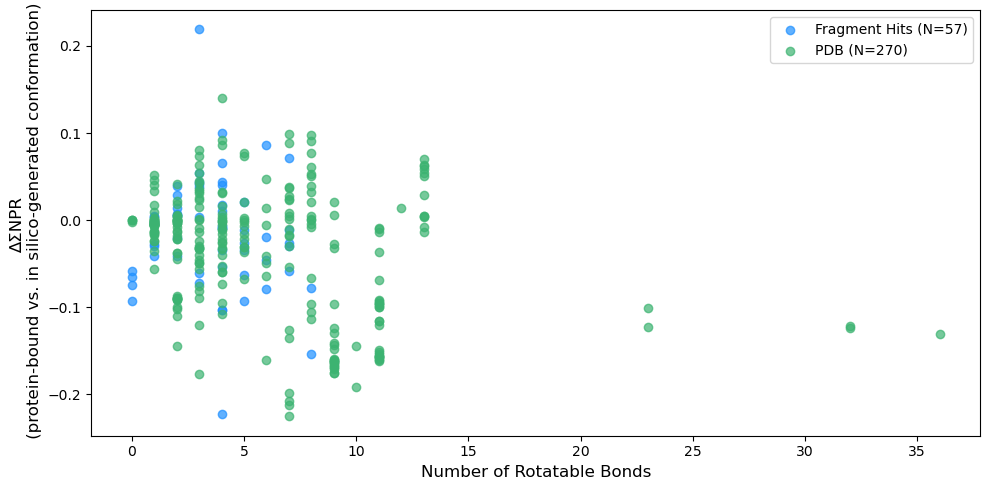

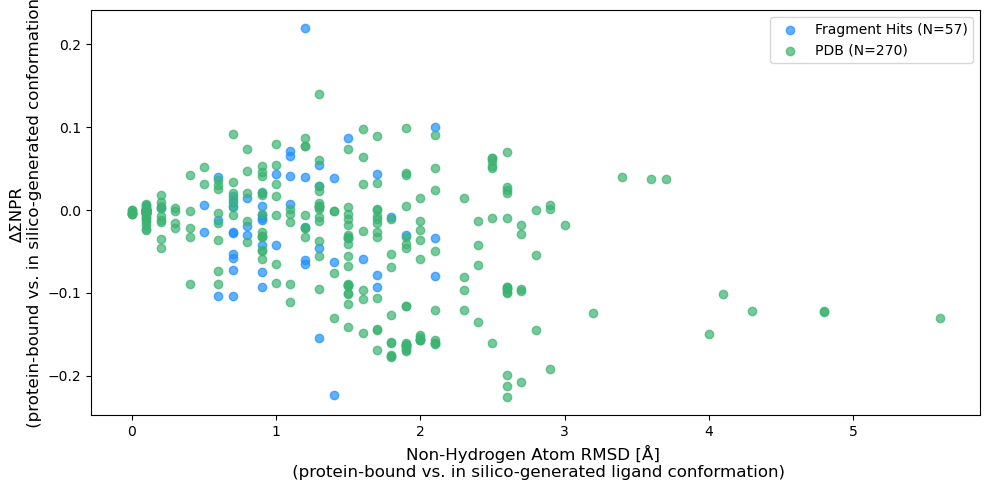

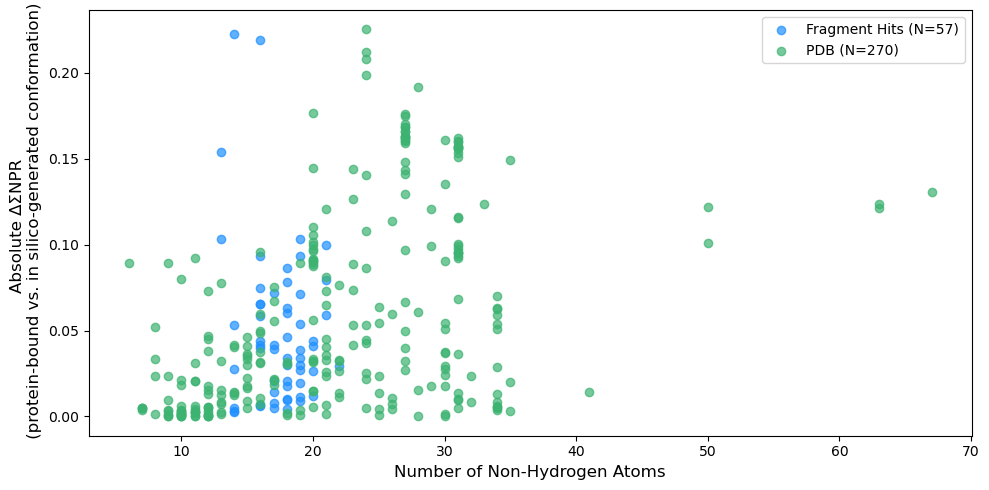

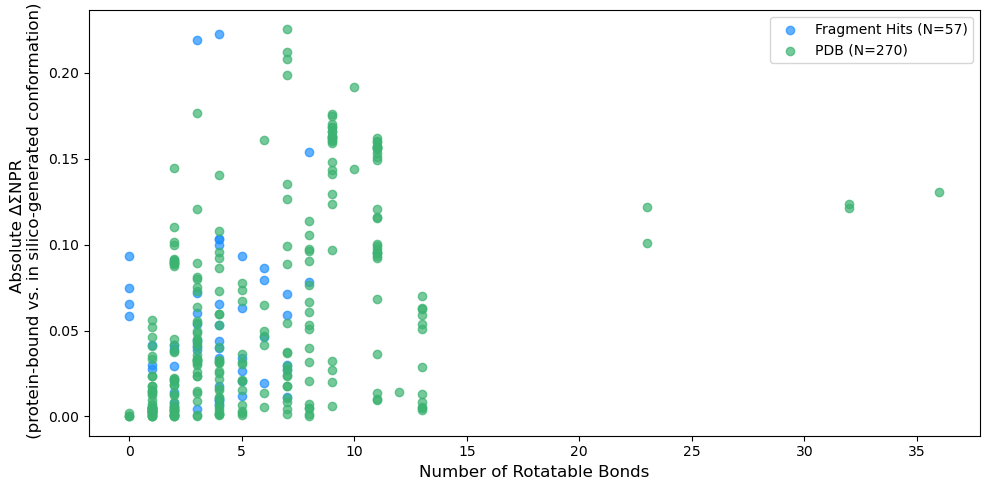

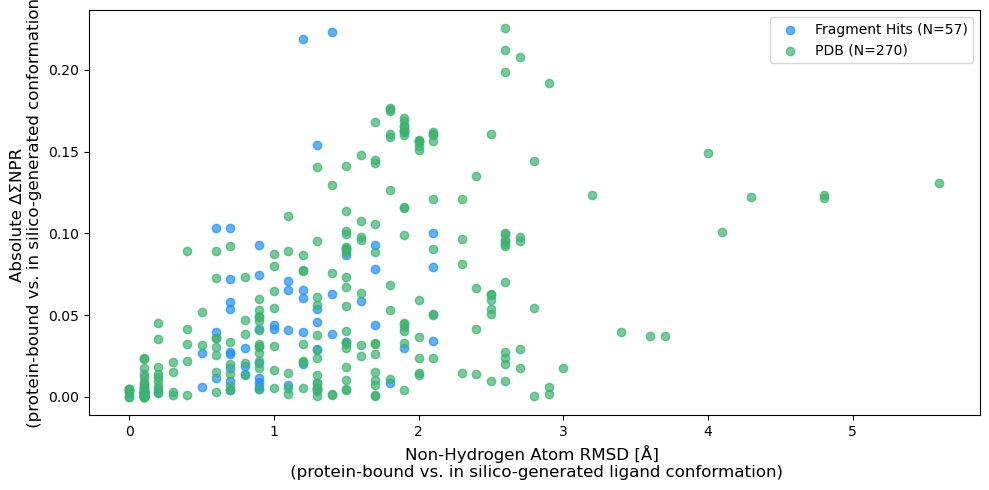

In [27]:
plot_all_scatter_plots(df, desc_comparison_path, incl_vs_RMSD=True)

# Read in grouped Data

In [28]:
def read_in_grouped_descriptor_data(suffix): 
    # Define path
    folder = protbound_path if suffix == 'protbound' else insilico_path if suffix == 'insilico' else None
    subfolder = os.path.join('Binding_site_agnostic', 'All')
    # Read in file
    df = pd.read_excel(os.path.join(folder, os.path.join(subfolder, 'Averaged_Descriptor_Values.xlsx')))

    # Rename columns
    df = df.rename(columns={'ΣNPR' : 'Sum_NPR', 'ΣNPR_1.07' : 'Sum_NPR_1.07', 
                            #'NumAromaticRings', 'NP_Likeness'
                            } )

    # Keep only data for datasets CF and PDB
    df = df[(df['Dataset'] == 'Fragment Hits') | (df['Dataset'] == 'PDB')].reset_index(drop=True)
    
    df = postprocess_df(df, suffix, grouped=True)
    
    return df

In [29]:
protbound_df_grouped = read_in_grouped_descriptor_data('protbound')
protbound_df_grouped.head(1) # 36 + 160 

196


,Dataset,ID,PDB_ID,Ligand_Instance,Standardized_SMILES,NRB,Num_Heavy_Atoms,Pocket,MW,HBA,HBD,LogP,TPSA,NAR,NP-Likeness,Fsp3_protbound,Fsp3_0.42_protbound,FCStereo_protbound,nSPS_protbound,nPBF_protbound,Sum_NPR_protbound,Sum_NPR_1.07_protbound,Num_Resolved_Atoms,Count
0,Fragment Hits,F001,[nan],['001_B_2'],['[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3...,3,18,['X'],250.253,4,2,0.2448,75.76,2,-1.393853,0.333333,False,0.166667,23.444444,0.032006,1.031809,False,[18],1


In [30]:
insilico_df_grouped = read_in_grouped_descriptor_data('insilico')
insilico_df_grouped.head(1)

196


,Dataset,ID,PDB_ID,Ligand_Instance,Standardized_SMILES,NRB,Num_Heavy_Atoms,Pocket,MW,HBA,HBD,LogP,TPSA,NAR,NP-Likeness,Fsp3_insilico,Fsp3_0.42_insilico,FCStereo_insilico,nSPS_insilico,nPBF_insilico,Sum_NPR_insilico,Sum_NPR_1.07_insilico,Count
0,Fragment Hits,F001,[nan],['001_B_2'],['[H]O[C@]1([H])C([H])([H])[C@@]([H])(C2=NC(C3...,3,18,['X'],250.253,4,2,0.2448,75.76,2,-1.393853,0.333333,False,0.166667,23.444444,0.047319,1.092296,True,1


In [31]:
# Merge the in_silico_confs_df and the df dataframes
df_grouped = protbound_df_grouped.merge(insilico_df_grouped, on=(info_cols+['Count']), how='inner')

# Convert IDs to string datatype
df_grouped['ID'] = df_grouped['ID'].apply(lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x))

save_cols = ['ID', 'Ligand_Instance', 'Standardized_SMILES', 'Pocket', 
            'Fsp3_protbound', 'FCStereo_protbound', 'nSPS_protbound',  'nPBF_protbound', 'nPBF_insilico']
# Save to file 
prepare_df_for_saving(df_grouped, save_cols).to_excel(
    os.path.join(comparison_path, "Fragments_Descriptor_Values.xlsx"), index=False)

# Drop column
df_grouped = df_grouped.drop(columns=[f"Standardized_SMILES"])

print(len(df_grouped))
df_grouped.head(1)

196


,Dataset,ID,PDB_ID,Ligand_Instance,NRB,Num_Heavy_Atoms,Pocket,MW,HBA,HBD,LogP,TPSA,NAR,NP-Likeness,Fsp3_protbound,Fsp3_0.42_protbound,FCStereo_protbound,nSPS_protbound,nPBF_protbound,Sum_NPR_protbound,Sum_NPR_1.07_protbound,Num_Resolved_Atoms,Count,Fsp3_insilico,Fsp3_0.42_insilico,FCStereo_insilico,nSPS_insilico,nPBF_insilico,Sum_NPR_insilico,Sum_NPR_1.07_insilico
0,Fragment Hits,F001,[nan],['001_B_2'],3,18,['X'],250.253,4,2,0.2448,75.76,2,-1.393853,0.333333,False,0.166667,23.444444,0.032006,1.031809,False,[18],1,0.333333,False,0.166667,23.444444,0.047319,1.092296,True


# Compare Averaged Descriptor Values

In [32]:
df_grouped = compare_descriptor_deltas(df_grouped) # desc_cols=desc_cols

# (out of 196) Ligands copies show different descriptor values for protbound vs. insilico:
0 	 Fsp3
0 	 Fsp3_0.42
0 	 FCStereo
0 	 nSPS
196 	 nPBF
196 	 Sum_NPR
34 	 Sum_NPR_1.07

For 72 ligands, the Sum_NPR value is higher for the protein-bound conformation than for the in silico generated one,
while the opposite is true for 124 ligands (from both datasets).
For 0 ligands, the Sum_NPR values are exactly the same.

The maximal absolute difference in the Sum_NPR descriptor values computed from the protein-bound vs. the in silico generated conformation is for: 
       ID  Delta_Sum_NPR  Sum_NPR_protbound  Sum_NPR_insilico
33   F312      -0.222942           1.136448          1.359390
8    F058       0.219121           1.307011          1.087891
105   AO8      -0.215128           1.074362          1.289490
108   B4Z      -0.198645           1.090845          1.289490
132   I5S      -0.191832           1.115630          1.307462

For 74 ligands, the nPBF value is higher for the protein-boun

In [33]:
df_grouped = df_grouped.sort_values(by=['Dataset', 'ID', 'PDB_ID', 'Ligand_Instance']).reset_index(drop=True)

df_grouped.to_excel(os.path.join(comparison_path, "Comparison_Averaged_Descriptor_Values.xlsx"), 
                                index=False)

In [34]:
compare_descriptor_deltas_by_dataset(df_grouped, desc_cols=desc_cols)


=== Dataset: Fragment Hits ===
# (out of 36) Ligands copies show different descriptor values for protbound vs. insilico:
0 	 Fsp3
0 	 Fsp3_0.42
0 	 FCStereo
0 	 nSPS
36 	 nPBF
36 	 Sum_NPR
11 	 Sum_NPR_1.07

For 12 ligands, the Sum_NPR value is higher for the protein-bound conformation than for the in silico generated one,
while the opposite is true for 24 ligands (from both datasets).
For 0 ligands, the Sum_NPR values are exactly the same.

The maximal absolute difference in the Sum_NPR descriptor values computed from the protein-bound vs. the in silico generated conformation is for: 
      ID  Delta_Sum_NPR  Sum_NPR_protbound  Sum_NPR_insilico
33  F312      -0.222942           1.136448          1.359390
8   F058       0.219121           1.307011          1.087891
34  F313      -0.154212           1.065159          1.219371
3   F012      -0.103346           1.011749          1.115095
4   F024      -0.103251           1.143180          1.246430

For 14 ligands, the nPBF value is highe


 Delta_nPBF vs. Num_Heavy_Atoms
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.009
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 0.097

 Delta_nPBF vs. NRB
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.001
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 0.022

 Delta_Abs_nPBF vs. Num_Heavy_Atoms
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.025
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 -0.091

 Delta_Abs_nPBF vs. NRB
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.003
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 0.061

 Delta_Sum_NPR vs. Num_Heavy_Atoms
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.047
Monotonic Correlation: 	 Spearman's Rank Correlation Coefficient (ρ) 	 -0.112

 Delta_Sum_NPR vs. NRB
Linear Correlation: 	 Pearson Correlation Coefficient (R²) 		 0.074
Monotonic Correlation: 	 Spea

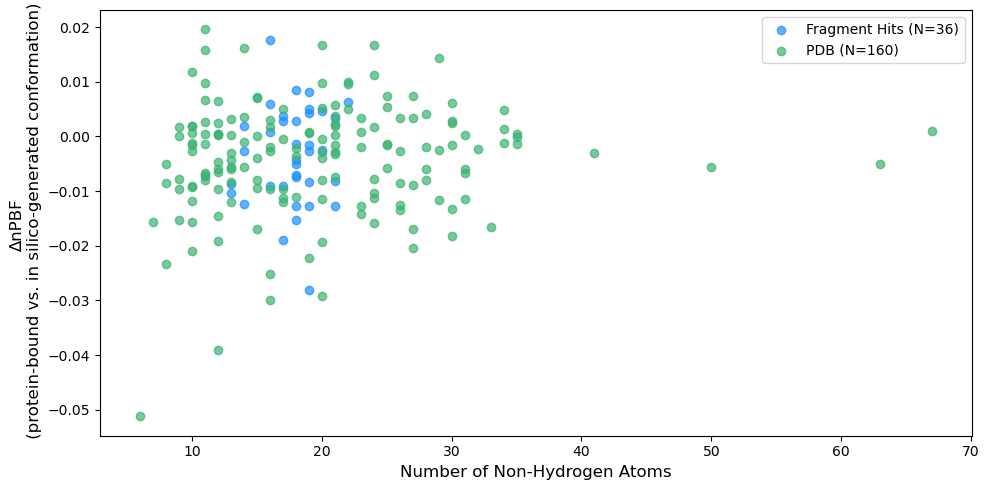

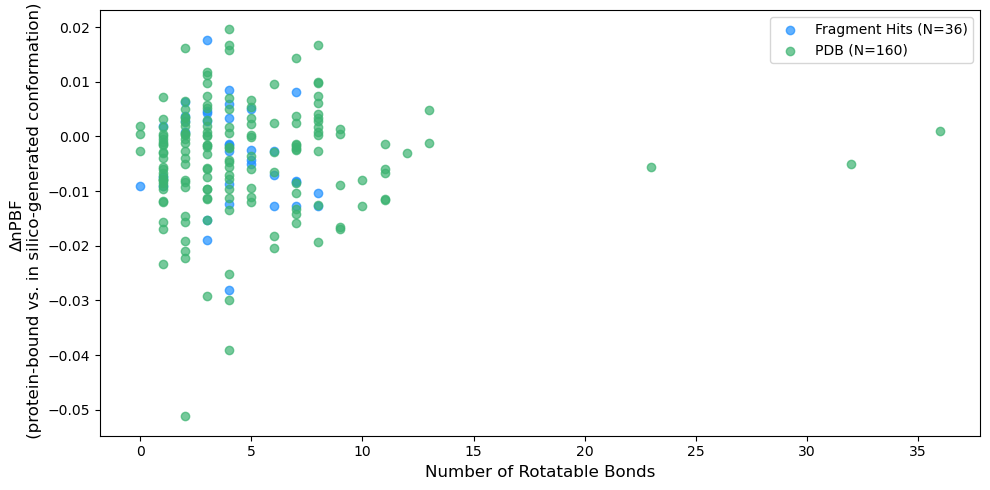

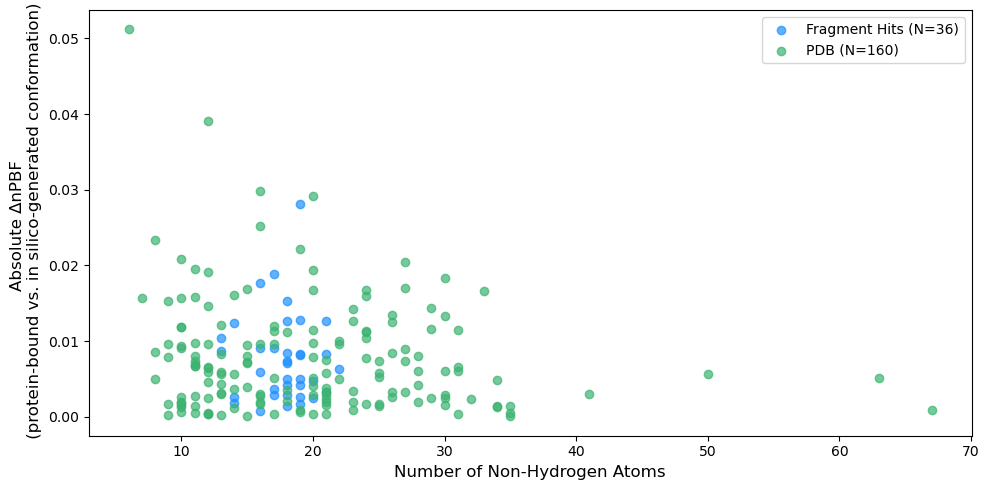

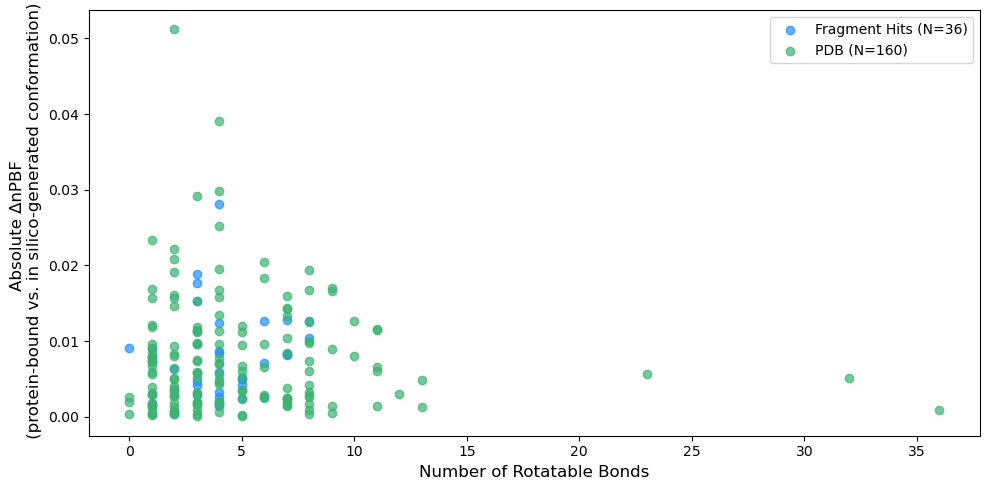

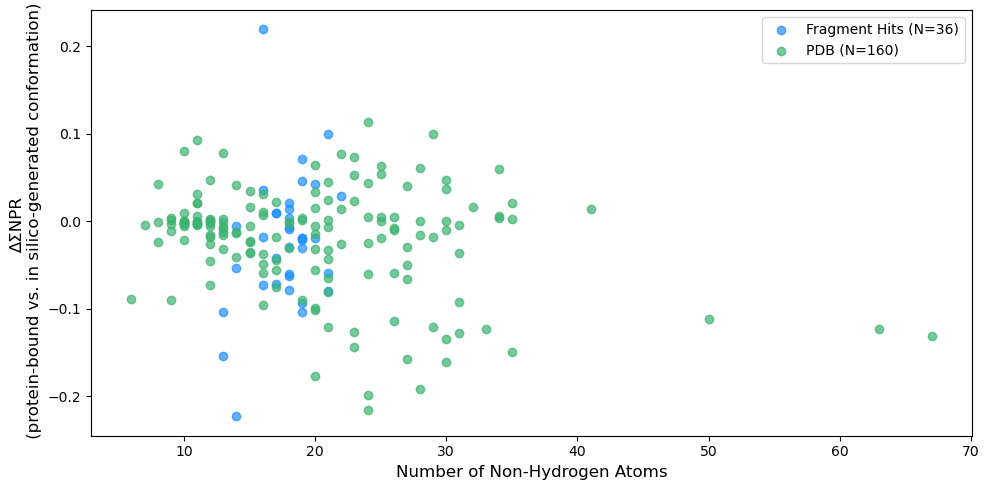

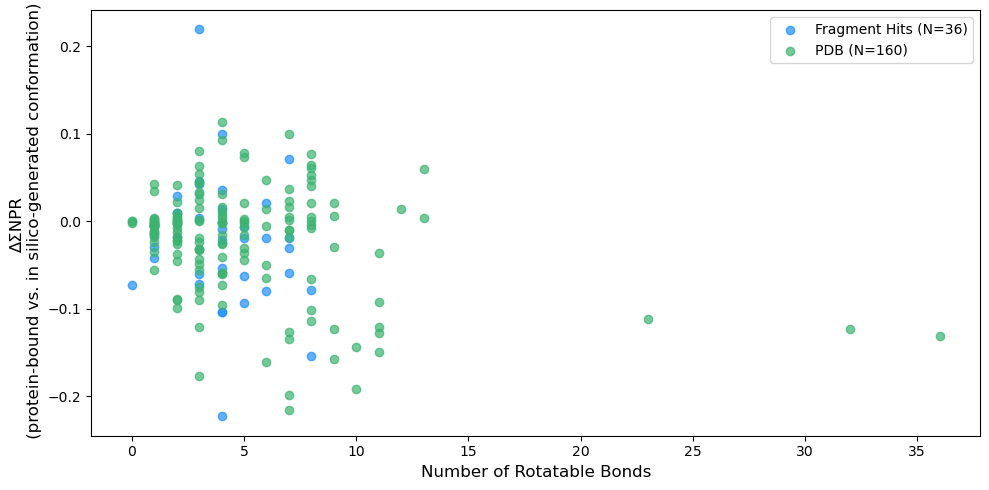

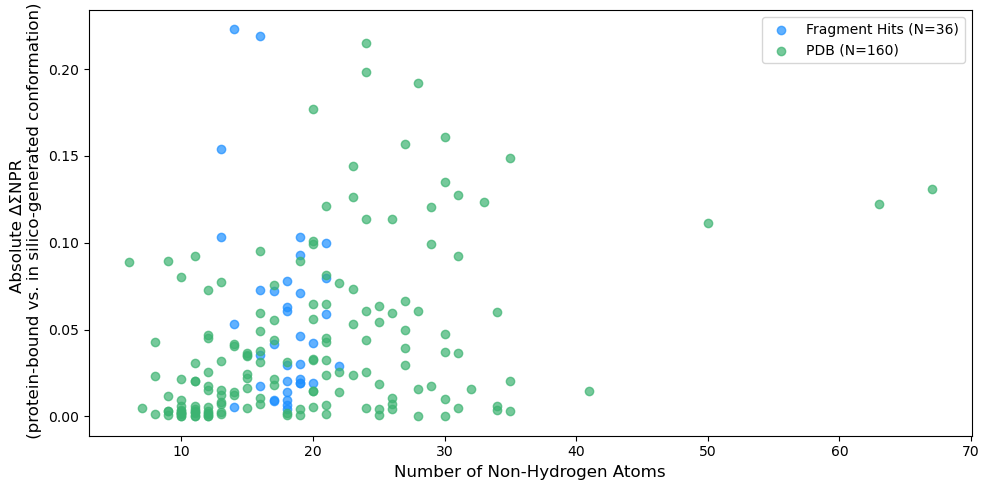

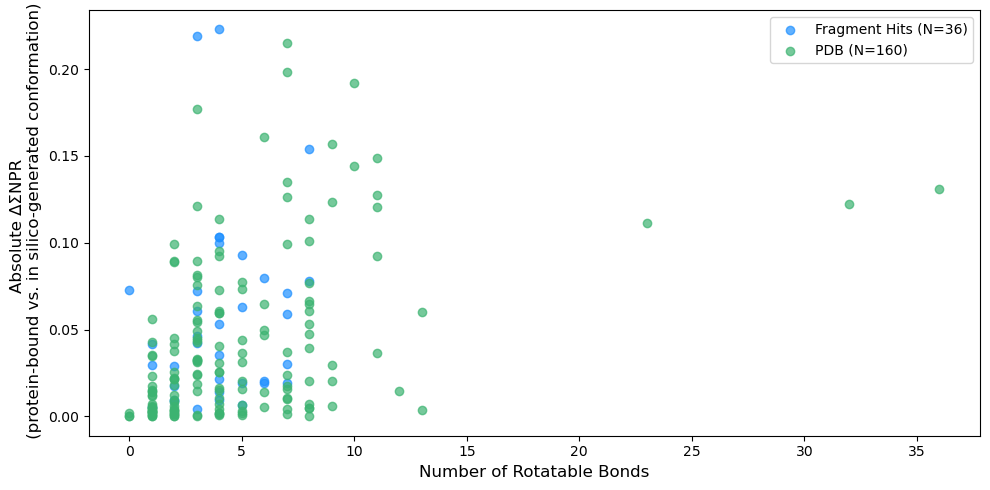

In [35]:
plot_all_scatter_plots(df_grouped, av_desc_comparison_path, incl_vs_RMSD=False)

# (Most) fully-resolved copies per ligand in any complex structure

### Count Plot

In [36]:
# Define a list of ligands, for which no fully resolved copy is present in any complex structure
# See Notebook 2_Data_Preparation_and_Overlap.ipynb
not_fully_resolved = ['46P', '7W8', '9NT', 'AO8', 'BVZ', 'F009', 'F012', 'GGB']

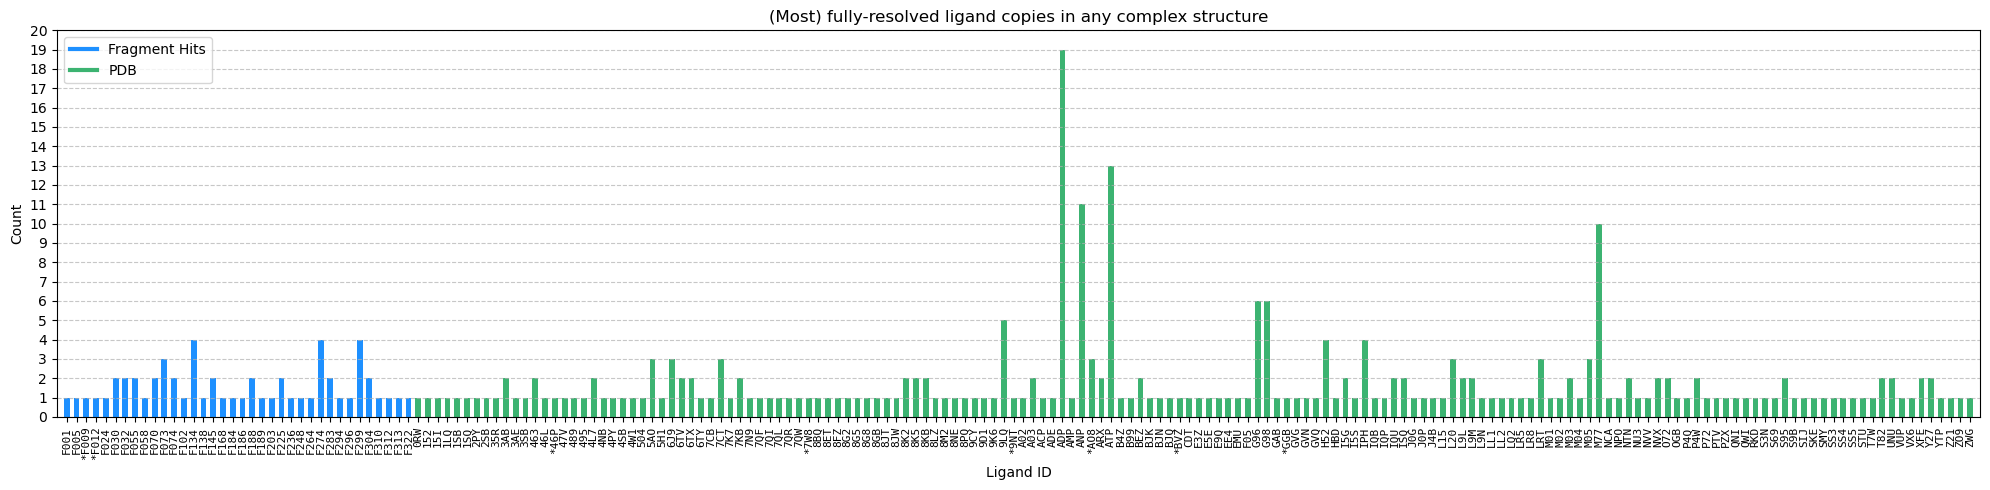

In [37]:
# Append an asterisks to the ID column for those fragments, which are not fully resolved, namely 009 and 012
df_grouped['ID'] = df_grouped.apply(lambda row: f"*{row['ID']}" if row['ID'] in not_fully_resolved else row['ID'], axis=1)

# Set the figure size
plt.figure(figsize=(20, 5))

# Create a color mapping based on the Dataset column
colors = np.where(df_grouped['Dataset'] == 'PDB', 'mediumseagreen', 'dodgerblue')

# Create the x positions for the bars
x_positions = np.arange(len(df_grouped['ID']))              # Create an array of positions

# Create the bar plot with adjusted width and title
plt.bar(x_positions, df_grouped['Count'], color=colors, width=0.6)
plt.title('(Most) fully-resolved ligand copies in any complex structure')

# Settings for the x-axis
plt.xticks(x_positions, df_grouped['ID'], rotation=90, fontsize=8, fontname='monospace')   
plt.xlim(-1, len(df_grouped))                               # Set limits to fit the bars tightly
plt.xlabel('Ligand ID')

# Settings for the y-axis
plt.yticks(np.arange(0, df_grouped['Count'].max() + 2, 1))  # Set y-axis ticks to be integers, increment 1
plt.ylabel('Count')                                              # Set y-axis label
plt.grid(axis='y', linestyle='--', alpha=0.7)                    # Add horizontal grid lines 

# Create a legend, thereby using proxy artists
cf_patch  = plt.Line2D([0], [0], color='dodgerblue',     lw=3, label='Fragment Hits')
pdb_patch = plt.Line2D([0], [0], color='mediumseagreen', lw=3, label='PDB')
plt.legend(handles=[cf_patch, pdb_patch], loc='upper left', fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.savefig(os.path.join(protbound_path, 'Countplot_(Most)_Fully_Resolved_Ligand_Copies.png'))
plt.show()

In [38]:
# Remove the asteriks from the ID column
df_grouped['ID'] = df_grouped['ID'].str.replace('*', '', regex=False)

### Histograms

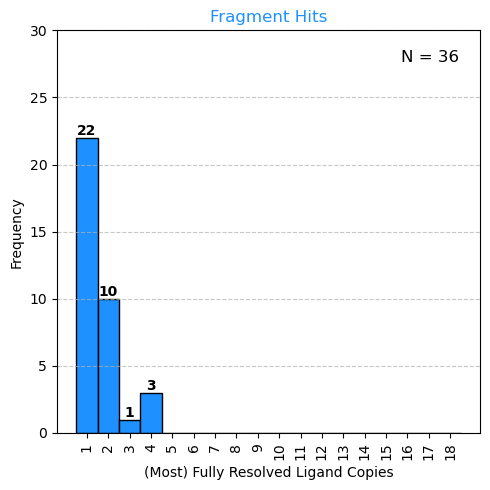

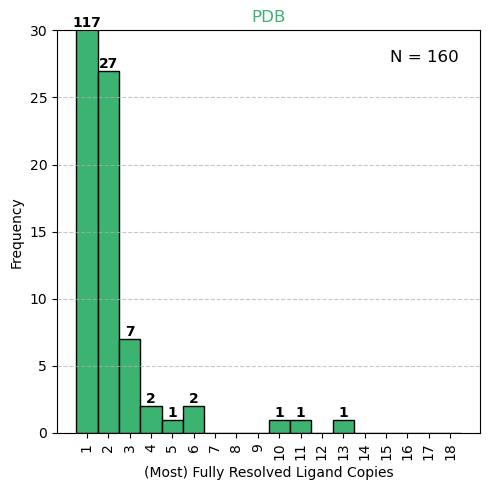

In [39]:
# Data for CF and PDB datasets
cf_data  = df_grouped[df_grouped['Dataset'] == 'Fragment Hits']['Count']
pdb_data = df_grouped[df_grouped['Dataset'] == 'PDB']['Count']

# Define the bin edges for this dataset
bin_edges = np.arange(0.5, df_grouped['Count'].max(), 1)
# bin_edges = np.arange(0.5, 21.5, 1)

x_label = '(Most) Fully Resolved Ligand Copies'
y_label = 'Frequency'
y_limit = 30
figsize = (5,5)

plot_histogram(data=cf_data, title='Fragment Hits', color='dodgerblue', figsize=figsize,
               bin_edges=bin_edges, x_label=x_label, y_label=y_label, 
               y_limit=y_limit, x_cutoff=None, bin_centers=True, 
               filename=os.path.join(protbound_path, 'Histogram_Ligand_Copies_CF.png'))

plot_histogram(data=pdb_data, title='PDB', color='mediumseagreen', figsize=figsize,
               bin_edges=bin_edges, x_label=x_label, y_label=y_label, 
               y_limit=y_limit, x_cutoff=None, bin_centers=True, 
               filename=os.path.join(protbound_path, 'Histogram_Ligand_Copies_PDB.png'))

Unsurprisingly, PDB Ligands which have been crystallized in more than 10 instances correspond to the kinase cofactors ATP and ADP, as well as to ANP.
PDB ligands crystallized 5 to 10 times, are 
| Ligand ID | PDB IDs | Ligand Name |
|:---------:|:-------:|:-----------:|
| 6J9 | 5IZJ, 5J5X | 4-(piperazin-1-yl)-7H-pyrrolo[2,3-d]pyrimidine |
| 9LQ | 5O5M, 5OL3, 5OT3, 6I2B, 6I2D | [2-[(4-isoquinolin-5-ylsulfonyl-1,4-diazepan-1-yl)methyl]phenyl]boronic acid |
| G96 | 3E8C | 4-[2-(4-amino-1,2,5-oxadiazol-3-yl)-6-{[(2R)-2-amino-3-phenylpropyl]oxy}-1-ethyl-1H-imidazo[4,5-c]pyridin-4-yl]-2-methylbut-3-yn-2-ol |
| G98 | 3E8E | 4-[2-(4-amino-2,5-dihydro-1,2,5-oxadiazol-3-yl)-6-{[(1S)-3-amino-1-phenylpropyl]oxy}-1-ethyl-1H-imidazo[4,5-c]pyridin-4-yl]-2-methylbut-3-yn-2-ol |
| M77 | 2GNI, 5LCP, 5NW8, 5O0E, 5OK3, 6EM2, 6ERW, 6I2A, 6I2C, 6YNA | 5-(1,4-diazepan-1-sulfonyl)isoquinoline = fasudil |


In [40]:
print(">1 Ligand Copy resolved for ..% of the ligands in the dataset")
print((df[df['ID'].duplicated(keep=False)].groupby('Dataset')['ID'].nunique() / df.groupby('Dataset')['ID'].nunique() * 100).round(0).astype(int))

>1 Ligand Copy resolved for ..% of the ligands in the dataset
Dataset
Fragment Hits    39
PDB              27
Name: ID, dtype: int64


# Ligands, for which >1 unique SMILES has been considered
This includes different protomers, tautomers etc.

In [41]:
# Group dataframe by Ligand ID and count unique SMILES (unique protomer/tautomers) per ID
unique_smiles_per_lig = df.groupby('ID')['Standardized_SMILES'].nunique()

# Extract IDs of Ligands for which more than one SMILES is present
ligs_with_mulitple_smiles = unique_smiles_per_lig[unique_smiles_per_lig > 1].index

# Filter df_filtered to keep only those rows
df_filtered = df[df['ID'].isin(ligs_with_mulitple_smiles)].reset_index(drop=True)

print(df_filtered.groupby('Dataset')['ID'].nunique())

Dataset
Fragment Hits    5
PDB              6
Name: ID, dtype: int64


In [42]:
def analyze_different_lig_forms(df, ligand_id):
    
    print(ligand_id)

    # Filter dataframe for the ligand ID
    df_lig = df[df['ID'] == ligand_id]

    # Sort by the same SMILES
    df_lig = df_lig.sort_values(by=['Standardized_SMILES'])

    # Extract the nPBF values 
    nPBF_insilico  = [round(x, 3) for x in df_lig['nPBF_insilico'].to_list()]
    nPBF_protbound = [round(x, 3) for x in df_lig['nPBF_protbound'].to_list()]
    print("nPBF insilico ", nPBF_insilico)
    print("Max. Delta nPBF insilico between multiple forms", round(max(nPBF_insilico) - min(nPBF_insilico), 3))

    print("\n nPBF protbound", nPBF_protbound)
    print("Max. Delta nPBF protbound between multiple forms", round(max(nPBF_insilico) - min(nPBF_insilico), 3))

    # Get unique SMILES and their counts
    smiles_counts = df_lig['Standardized_SMILES'].value_counts()
    
    # Convert SMILES to Mol objects
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_counts.index]
    
    # Prepare legends showing counts
    legends = [f'{count}' for count in smiles_counts.values]
    
    # Generate grid image
    img = Draw.MolsToGridImage(mols, molsPerRow=len(smiles_counts), subImgSize=(200, 200), legends=legends)

    return display(img)

9LQ
nPBF insilico  [0.039, 0.039, 0.039, 0.041, 0.041]
Max. Delta nPBF insilico between multiple forms 0.002

 nPBF protbound [0.044, 0.043, 0.041, 0.042, 0.041]
Max. Delta nPBF protbound between multiple forms 0.002


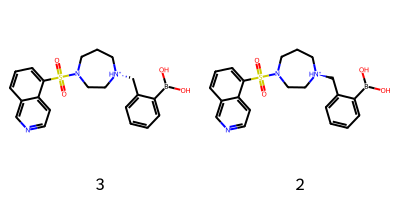

ADP
nPBF insilico  [0.043, 0.043, 0.043, 0.043, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045, 0.045]
Max. Delta nPBF insilico between multiple forms 0.002

 nPBF protbound [0.027, 0.027, 0.027, 0.027, 0.026, 0.027, 0.027, 0.027, 0.027, 0.026, 0.027, 0.028, 0.027, 0.028, 0.028, 0.027, 0.033, 0.027, 0.027]
Max. Delta nPBF protbound between multiple forms 0.002


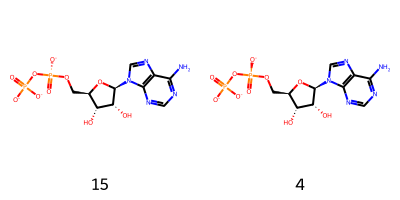

ANP
nPBF insilico  [0.028, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033]
Max. Delta nPBF insilico between multiple forms 0.005

 nPBF protbound [0.026, 0.025, 0.026, 0.026, 0.025, 0.026, 0.025, 0.025, 0.026, 0.026, 0.025]
Max. Delta nPBF protbound between multiple forms 0.005


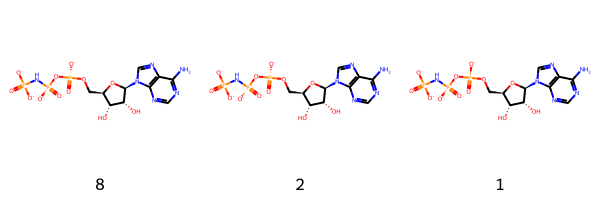

ATP
nPBF insilico  [0.036, 0.029, 0.029, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]
Max. Delta nPBF insilico between multiple forms 0.01

 nPBF protbound [0.025, 0.026, 0.026, 0.026, 0.026, 0.026, 0.024, 0.026, 0.026, 0.027, 0.026, 0.026, 0.026]
Max. Delta nPBF protbound between multiple forms 0.01


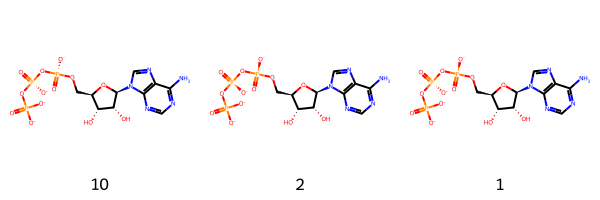

BEZ
nPBF insilico  [0.0, 0.003]
Max. Delta nPBF insilico between multiple forms 0.003

 nPBF protbound [0.002, 0.005]
Max. Delta nPBF protbound between multiple forms 0.003


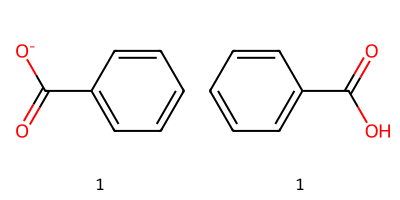

F134
nPBF insilico  [0.04, 0.04, 0.04, 0.039]
Max. Delta nPBF insilico between multiple forms 0.001

 nPBF protbound [0.046, 0.043, 0.041, 0.036]
Max. Delta nPBF protbound between multiple forms 0.001


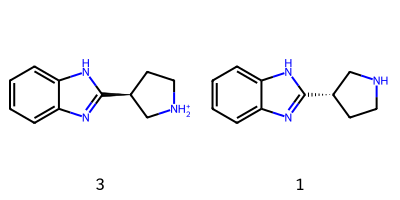

F145
nPBF insilico  [0.046, 0.023]
Max. Delta nPBF insilico between multiple forms 0.023

 nPBF protbound [0.037, 0.038]
Max. Delta nPBF protbound between multiple forms 0.023


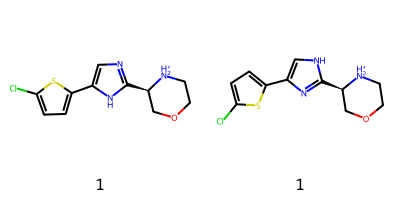

F188
nPBF insilico  [0.053, 0.049]
Max. Delta nPBF insilico between multiple forms 0.004

 nPBF protbound [0.054, 0.042]
Max. Delta nPBF protbound between multiple forms 0.004


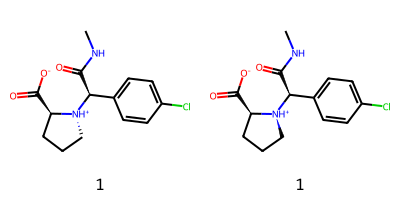

F225
nPBF insilico  [0.057, 0.042]
Max. Delta nPBF insilico between multiple forms 0.015

 nPBF protbound [0.047, 0.042]
Max. Delta nPBF protbound between multiple forms 0.015


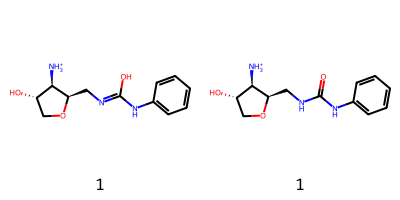

F283
nPBF insilico  [0.045, 0.051]
Max. Delta nPBF insilico between multiple forms 0.006

 nPBF protbound [0.051, 0.031]
Max. Delta nPBF protbound between multiple forms 0.006


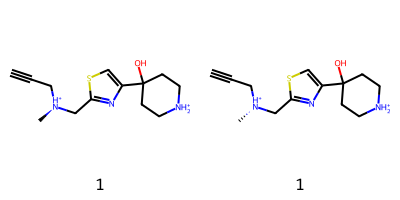

T82
nPBF insilico  [0.047, 0.039]
Max. Delta nPBF insilico between multiple forms 0.008

 nPBF protbound [0.036, 0.046]
Max. Delta nPBF protbound between multiple forms 0.008


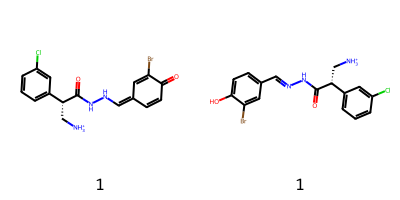

In [43]:
for lig in ligs_with_mulitple_smiles:
    analyze_different_lig_forms(df_filtered, lig)